## **INDIAN MOVIE RATING PREDICTION**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
movies = pd.read_csv("IMDb Movies India.csv", encoding='latin-1')
movies

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
...,...,...,...,...,...,...,...,...,...,...
15504,Zulm Ko Jala Doonga,(1988),NaN,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,(2005),NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,(1988),NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
movies.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

### Data Cleaning

In [4]:
movies.dropna(subset=['Rating'], inplace=True)

In [5]:
movies.isnull().sum()

Name           0
Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

In [6]:
movies.drop_duplicates(inplace=True)

In [7]:
movies['Duration'] = movies['Duration'].replace("[^0-9]", "", regex = True)
movies['Duration'].fillna('0', inplace=True)
movies['Duration'] = movies['Duration'].astype("float")
movies['Duration'] = movies['Duration'].replace(0.0, round(movies.Duration.mean()), regex = True)

In [8]:
movies.isnull().sum()

Name          0
Year          0
Duration      0
Genre       102
Rating        0
Votes         0
Director      5
Actor 1     125
Actor 2     200
Actor 3     292
dtype: int64

In [9]:
movies['Name'] = movies['Name'].replace("[^a-zA-Z0-9 ()]", "", regex = True)
movies['Year'] = movies['Year'].replace("[()]", "", regex = True)


movies.fillna({'Genre': movies['Genre'].mode()[0],
           'Director': 'Unknown', 'Actor 1': 'Unknown', 
           'Actor 2': 'Unknown', 'Actor 3': 'Unknown'}, inplace=True)

In [10]:
movies.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [11]:
movies.dtypes

Name         object
Year         object
Duration    float64
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [12]:
movies['Year'] = movies['Year'].astype("int")
movies['Votes'] = movies['Votes'].replace("[^0-9]", "", regex = True)
movies['Votes'] = movies['Votes'].astype("int")

In [13]:
movies

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...,...
15501,Zulm Ki Hukumat,1992,98.0,"Action, Crime, Drama",5.3,135,Bharat Rangachary,Dharmendra,Moushumi Chatterjee,Govinda
15503,Zulm Ki Zanjeer,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15504,Zulm Ko Jala Doonga,1988,98.0,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [14]:
movies.Genre.unique()

def split_genre_column(movies,Genre):
   
    movies['Genre1'] = movies[Genre].str.split(',', expand=True)[0]
    movies['Genre2'] = movies[Genre].str.split(',', expand=True)[1]
    movies['Genre3'] = movies[Genre].str.split(',', expand=True)[2]
    return movies

split_genre_column(movies,'Genre')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre1,Genre2,Genre3
1,Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,Drama,None,None
3,Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,Comedy,Romance,None
5,Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,Comedy,Drama,Musical
6,Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,Drama,Romance,War
8,A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,Horror,Mystery,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,Zulm Ki Hukumat,1992,98.0,"Action, Crime, Drama",5.3,135,Bharat Rangachary,Dharmendra,Moushumi Chatterjee,Govinda,Action,Crime,Drama
15503,Zulm Ki Zanjeer,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth,Action,Crime,Drama
15504,Zulm Ko Jala Doonga,1988,98.0,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand,Action,None,None
15505,Zulmi,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,Action,Drama,None


### To set average rating of each unique actors and directors as separate column.

In [15]:
def get_column_avg_rating(a):
    df1 = movies[a].value_counts()

    avg_rating = dict()
    for i in range(len(df1)):
        r = movies[movies[a] == df1.index[i]].Rating.sum()/df1.values[i]
        avg_rating[df1.index[i]] = round(r, 3)
    
    return avg_rating

for i in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    avg_rating = get_column_avg_rating(i)
    avg_rt = []
    for j in movies[i]:
        avg_rt.append(avg_rating[j])
    movies[f"{i} Avg Rating"] = avg_rt

In [16]:
movies.isnull().sum()

Name                      0
Year                      0
Duration                  0
Genre                     0
Rating                    0
Votes                     0
Director                  0
Actor 1                   0
Actor 2                   0
Actor 3                   0
Genre1                    0
Genre2                 2813
Genre3                 5107
Director Avg Rating       0
Actor 1 Avg Rating        0
Actor 2 Avg Rating        0
Actor 3 Avg Rating        0
dtype: int64

In [17]:
movies.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre1,Genre2,Genre3,Director Avg Rating,Actor 1 Avg Rating,Actor 2 Avg Rating,Actor 3 Avg Rating
1,Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,Drama,None,None,7.000,6.850,7.000,7.000
3,Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,Comedy,Romance,None,4.400,5.420,4.400,4.450
5,Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,Comedy,Drama,Musical,5.359,4.789,5.787,5.846
6,Yahaan,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,Drama,Romance,War,7.500,5.356,6.050,6.500
8,A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,Horror,Mystery,Thriller,5.600,5.600,5.883,5.600


### Data Visualization

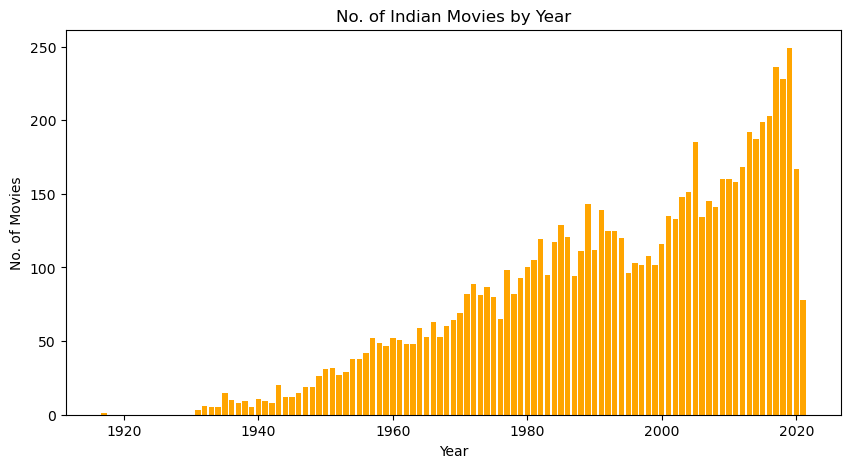

In [18]:
countmovies = movies['Year'].value_counts()
plt.figure(figsize = (10,5))
plt.bar(countmovies.index, countmovies.values, color = ['orange'])
plt.title("No. of Indian Movies by Year")
plt.xlabel("Year")
plt.ylabel("No. of Movies")
plt.show()

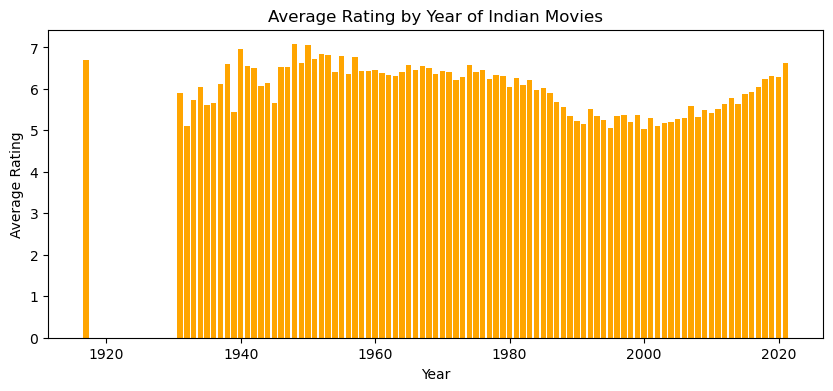

In [19]:
rating_by_year = movies.groupby(by = ['Year']).Rating.mean()
plt.figure(figsize = (10,4))
plt.title("Average Rating by Year of Indian Movies")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.bar(rating_by_year.index, rating_by_year.values, color = ['orange'])
plt.show()

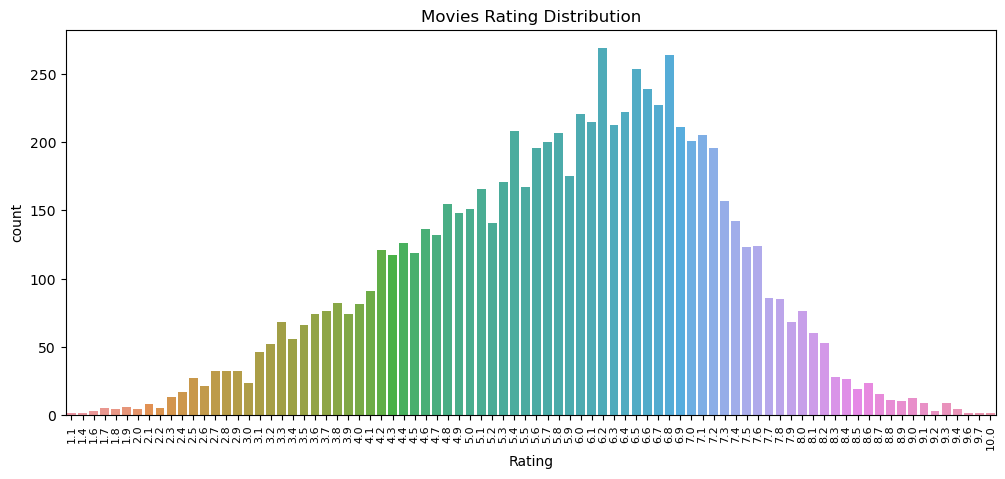

In [20]:
fig = plt.figure(figsize=(12,5))
plt.title("Movies Rating Distribution")
xticks_values = np.linspace(0, 10, 11)
# Set x-ticks with decimal format
plt.xticks(xticks_values, [f'{val:.2f}' for val in xticks_values], rotation = 90, fontsize = 8)

sb.countplot(data=movies, x='Rating')
plt.show()

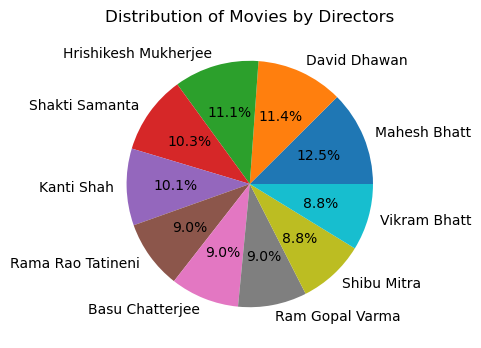

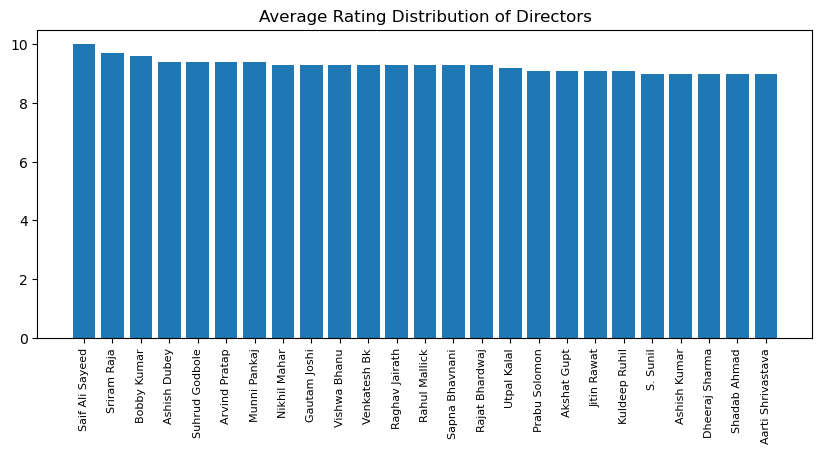

In [21]:
plt.figure(figsize=(10, 4))
movies.Director.value_counts().head(10).plot.pie(autopct = "%1.1f%%")
plt.ylabel(ylabel='')
plt.title("Distribution of Movies by Directors")
plt.show()

plt.figure(figsize=(10, 4))
rate_dir = movies.groupby(by = 'Director').Rating.mean().sort_values(ascending=False).head(25)
plt.bar(rate_dir.index, rate_dir.values)
plt.title("Average Rating Distribution of Directors")
plt.xticks(rotation = 90, fontsize = 8)
plt.show()

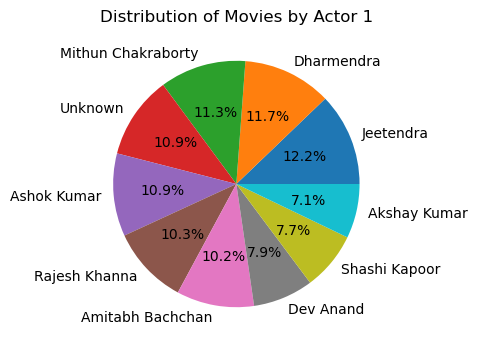

In [22]:
plt.figure(figsize=(10, 4))
movies['Actor 1'].value_counts().head(10).plot.pie(autopct = "%1.1f%%")
plt.ylabel(ylabel='')
plt.title("Distribution of Movies by Actor 1")
plt.show()

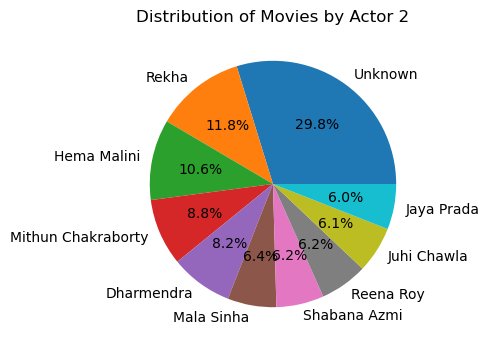

In [23]:
plt.figure(figsize=(10, 4))
movies['Actor 2'].value_counts().head(10).plot.pie(autopct = "%1.1f%%")
plt.ylabel(ylabel='')
plt.title("Distribution of Movies by Actor 2")
plt.show()

### Data Transformation

In [24]:
movies.drop(['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], axis = 1, inplace = True)

In [25]:
col = ['Name', 'Genre1', 'Genre2', 'Genre3']
ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
movies[col] = ord_enc.fit_transform(movies[col])
movies

,Name,Year,Duration,Rating,Votes,Genre1,Genre2,Genre3,Director Avg Rating,Actor 1 Avg Rating,Actor 2 Avg Rating,Actor 3 Avg Rating
1,2337.0,2019,109.0,7.0,8,7.0,19.0,20.0,7.000,6.850,7.000,7.000
3,7189.0,2019,110.0,4.4,35,4.0,13.0,20.0,4.400,5.420,4.400,4.450
5,699.0,1997,147.0,4.7,827,4.0,5.0,11.0,5.359,4.789,5.787,5.846
6,7195.0,2005,142.0,7.4,1086,7.0,13.0,18.0,7.500,5.356,6.050,6.500
8,0.0,2012,82.0,5.6,326,11.0,12.0,17.0,5.600,5.600,5.883,5.600
...,...,...,...,...,...,...,...,...,...,...,...,...
15501,7364.0,1992,98.0,5.3,135,0.0,4.0,5.0,5.571,5.743,6.075,4.896
15503,7365.0,1989,125.0,5.8,44,0.0,4.0,5.0,5.886,6.329,5.800,5.850
15504,7366.0,1988,98.0,4.6,11,0.0,19.0,20.0,4.075,6.026,3.700,4.600
15505,7368.0,1999,129.0,4.5,655,0.0,5.0,20.0,5.225,5.482,4.645,5.617


#### Scaling the dataset

In [26]:
X = movies.drop(columns=['Rating'])
y = movies['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [27]:
ss = StandardScaler()
Xt_train = ss.fit_transform(X_train)
Xt_test = ss.transform(X_test)

### **Selecting Different models on Cross-Validation Score to get best prediction model**

In [124]:
lr_model = LinearRegression()

# Perform cross-validation
scores = cross_val_score(lr_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")

Cross-Validation Scores: [0.48547471 0.46398899 0.48129978 0.49294977 0.41016614]
Mean CV Score: 0.46677587751278204
Standard Deviation CV Score: 0.029859978901463545


In [125]:
ridge_model = Lasso() #Ridge() 
# Perform cross-validation
scores = cross_val_score(ridge_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")

Cross-Validation Scores: [1.6605664  1.80396664 1.5817683  1.83034012 1.65380156]
Mean CV Score: 1.706088606147785
Standard Deviation CV Score: 0.09516332469985972


In [126]:
svc_model = SVR(kernel='linear')
# Perform cross-validation
scores = cross_val_score(svc_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")


Cross-Validation Scores: [0.51697193 0.4613984  0.49476353 0.49683646 0.42064976]
Mean CV Score: 0.47812401575038493
Standard Deviation CV Score: 0.03382078089663006


In [127]:
svc_model = SVR()
# Perform cross-validation
scores = cross_val_score(svc_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")


Cross-Validation Scores: [0.39592686 0.39018508 0.43448059 0.45391643 0.35545617]
Mean CV Score: 0.405993026309058
Standard Deviation CV Score: 0.034679638713280315


#### Moving to more complex Algorithms

### RandomForestRegressor

In [128]:
rfc_model = RandomForestRegressor(random_state = 10)
# Perform cross-validation
scores = cross_val_score(rfc_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")

Cross-Validation Scores: [0.40864501 0.37680498 0.41830426 0.40540699 0.3629562 ]
Mean CV Score: 0.39442348841773534
Standard Deviation CV Score: 0.020946513024744057


In [129]:
rfc_model = RandomForestRegressor(random_state = 10)
rfc_model.fit(Xt_train, y_train)

# Make predictions
y_train_pred = rfc_model.predict(Xt_train)
y_test_pred = rfc_model.predict(Xt_test)

print("Training R2 Score:", r2_score(y_train, y_train_pred))
print("Testing R2 Score:", r2_score(y_test, y_test_pred))

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training R2 Score: 0.9719845969813875
Testing R2 Score: 0.7872579367628011
Training MSE: 0.053654230846943866
Testing MSE: 0.40218788888888884


### GradientBoostingRegressor

In [130]:
gbr_model = GradientBoostingRegressor(random_state = 10)
# Perform cross-validation
scores = cross_val_score(gbr_model, Xt_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print(f"Cross-Validation Scores: {-scores}")
print(f"Mean CV Score: {-np.mean(scores)}")
print(f"Standard Deviation CV Score: {np.std(scores)}")

Cross-Validation Scores: [0.40714312 0.37425627 0.43252509 0.40851136 0.34651812]
Mean CV Score: 0.39379079383915155
Standard Deviation CV Score: 0.030038737269630557


In [131]:
gbr_model = GradientBoostingRegressor(random_state = 10)
gbr_model.fit(Xt_train, y_train)

# Make predictions
y_train_pred = gbr_model.predict(Xt_train)
y_test_pred = gbr_model.predict(Xt_test)

print("Training R2 Score:", r2_score(y_train, y_train_pred))
print("Testing R2 Score:", r2_score(y_test, y_test_pred))

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training R2 Score: 0.8298224475471742
Testing R2 Score: 0.7866786909305951
Training MSE: 0.3259187696927175
Testing MSE: 0.40328295046184576


#### Now, we will hyperparameter tuning of GradientBoostRegressor, to get best model parameters, using GridSearchCV with new features formed training dataset.

In [30]:
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

gbr_model = GradientBoostingRegressor(random_state = 10)
gscv = GridSearchCV(gbr_model, param_grid = param_grid_gbr, cv = 5, verbose = 2, n_jobs = -1)
gscv.fit(Xt_train, y_train)

best_params = gscv.best_params_
best_score = gscv.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score}")

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


##### Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.8}

In [28]:
gbr = GradientBoostingRegressor(learning_rate= 0.05, max_depth= 5, min_samples_leaf = 1, 
                                      min_samples_split = 5, n_estimators = 400, subsample = 0.8, random_state = 10)

gbr.fit(Xt_train, y_train)

print("Training Score:", gbr.score(Xt_train, y_train))
print("Testing Score:", gbr.score(Xt_test, y_test))

# Make predictions
y_train_pred = gbr.predict(Xt_train)
y_test_pred = gbr.predict(Xt_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training Score: 0.9246515511732515
Testing Score: 0.8020125400655829
Training MSE: 0.1443050119473074
Testing MSE: 0.37429437942751576


##### Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}

In [29]:
gbr = GradientBoostingRegressor(learning_rate= 0.05, max_depth= 5, min_samples_leaf = 2, max_features = 'sqrt',
                                      min_samples_split = 2, n_estimators = 300, subsample = 0.8, random_state = 10)


gbr.fit(Xt_train, y_train)

print("Training Score:", gbr.score(Xt_train, y_train))
print("Testing Score:", gbr.score(Xt_test, y_test))

# Make predictions
y_train_pred = gbr.predict(Xt_train)
y_test_pred = gbr.predict(Xt_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")

Training Score: 0.8921937126757553
Testing Score: 0.8027747357210766
Training MSE: 0.20646725742278701
Testing MSE: 0.37285345205782344


### The above model is Best Fit Model for IMDb Indian Movie Rating Prediction

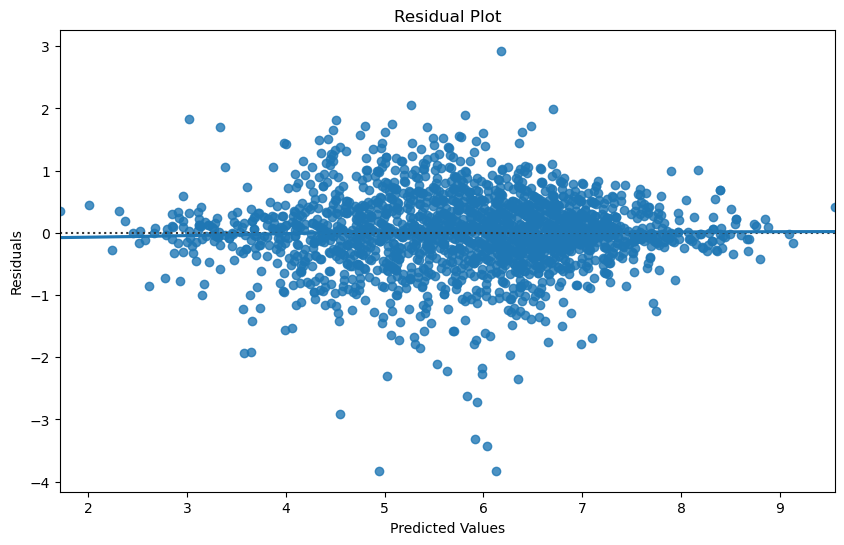

In [32]:
y_pred = gbr.predict(Xt_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sb.residplot(x = y_pred, y = residuals, lowess=True)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


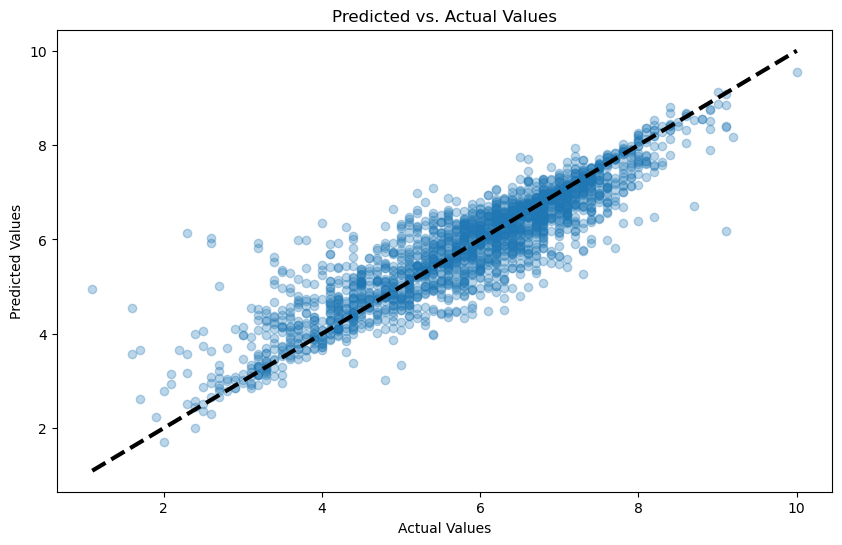

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()

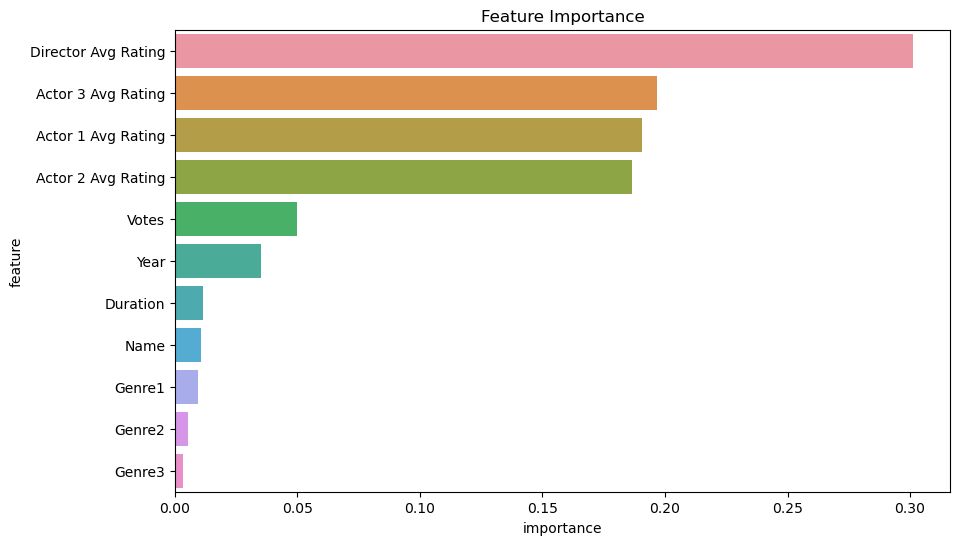

In [34]:
feature_importances = gbr.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sb.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


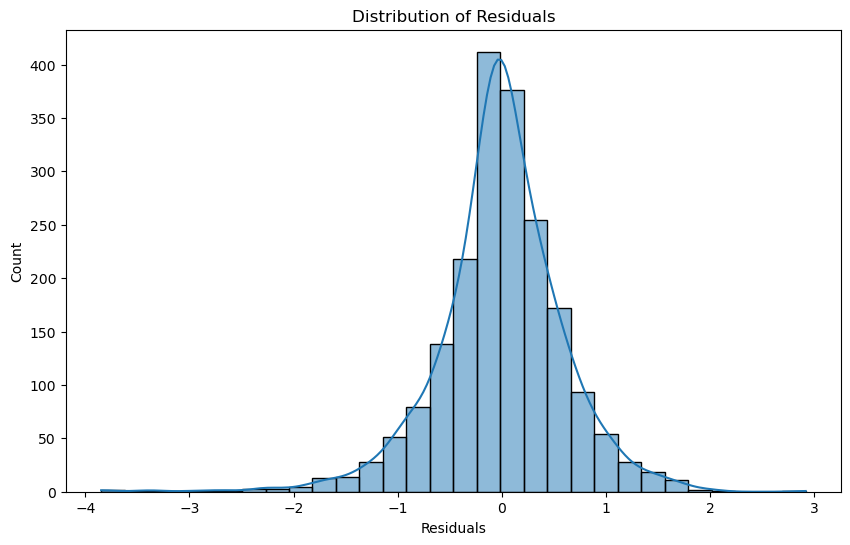

In [35]:
plt.figure(figsize=(10, 6))
sb.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()
